#### Perform a variety of pre-processing steps on images

* Image Loading
* Image Resizing (All images are 224 X 224 X 3 in jpg format)
* Image Cropping (All images in the dataset have been cropped so that only the image of a single card is present and the card occupies well over 50% of the pixels in the image)
* Convert to Grayscale 
* Image Enhancement (histogram equalization, sharpening, noise reduction, etc.)
* Normalization
* Data Augmentation: Apply data augmentation techniques to increase the size and diversity of your dataset. This can include random rotations, flips, translations, or other transformations to simulate different viewpoints or variations in lighting conditions.
* Image Filtering: : Apply filters or convolutions to smooth the image or enhance specific features. This can include techniques such as blurring (e.g., Gaussian blur), edge detection (e.g., Sobel, Canny), or other spatial filters.


In [20]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve, binary_fill_holes
from scipy.stats import mode

from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import rotate, hough_line, hough_line_peaks, resize
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local


## Image Loading

In [2]:
# Load images from csv file

path = pd.read_csv('Dataset/cards.csv')
path_df = pd.DataFrame(path)
# For column names that contain space, replace the space with an underscore
path_df.columns = [c.replace(' ', '_') for c in path_df.columns]
path_df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


## Check Image Size

In [3]:
# All images are 224 X 224 X 3 in jpg format
# Double check by printing out unique shapes of images

dataset_folder = "Dataset/train"

folders = os.listdir(dataset_folder)
images = []
image_shapes = []
for folder in folders:
  folder_path = os.path.join(dataset_folder, folder)
  for path in os.listdir(folder_path):
    image_path = os.path.join(os.path.join(dataset_folder, folder), path)
    image = cv2.imread(image_path)
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    images.append(image)
    
    # Obtain shape of each image and store them in an array
    (width, height) = image.shape[1], image.shape[0]
    image_shapes.append((width, height))
    
# Return only unique shapes
unique_shapes = list(set(image_shapes))
print(unique_shapes)

[(224, 224)]


## Convert Images to Grayscale

In [4]:
# Convert images to grayscale

def convert_to_grayscale(filepath):
    filename = 'Dataset/' + filepath
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

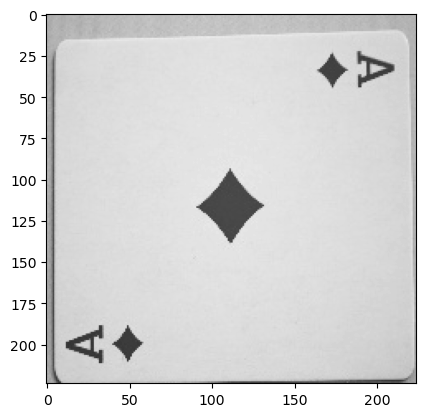

In [5]:
# Test if image is actually gray

test_colored_image = 'train/ace of diamonds/001.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
plt.imshow(test_gray_img, cmap='gray', vmin=0, vmax=255)

## Image Enhancement (Work in Progress)

Apply techniques to improve the image quality or highlight specific features. This may include operations such as contrast adjustment, histogram equalization, sharpening, or noise reduction.

(Working on it below)

#### Sharpening
Enhance the edges and details in the images to make them visually sharper. Techniques like unsharp masking (cv2.filter2D() in OpenCV) or high-pass filtering can be used to emphasize high-frequency components and enhance image details.

#### Noise Reduction
Apply noise reduction techniques to remove or reduce unwanted noise or artifacts in the images. Common approaches include Gaussian blurring (cv2.GaussianBlur() in OpenCV) or median filtering (cv2.medianBlur() in OpenCV).

#### Image Denoising 
Apply denoising techniques to reduce noise while preserving important image details. Methods like non-local means denoising (cv2.fastNlMeansDenoisingColored() in OpenCV) or bilateral filtering (cv2.bilateralFilter() in OpenCV) can be effective in reducing noise.

### Contrast Stretch

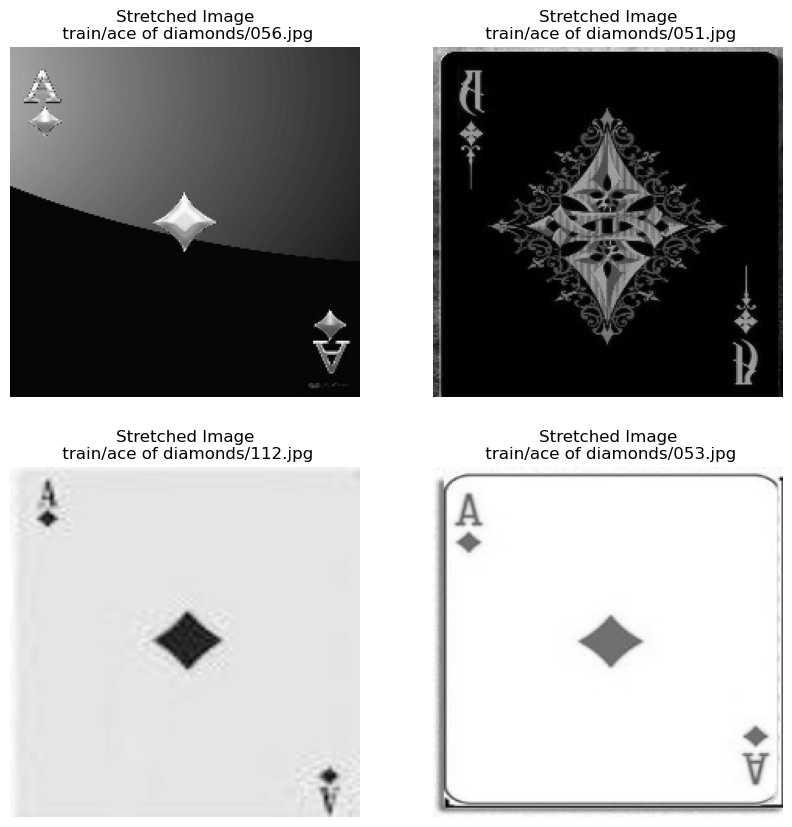

In [6]:
# Contrast Stretch/Adjustment

image_directory = 'Dataset'

# Testing four images first
image_filenames = ['train/ace of diamonds/056.jpg', 
                   'train/ace of diamonds/051.jpg', 
                   'train/ace of diamonds/112.jpg', 
                   'train/ace of diamonds/053.jpg']

# Set up the subplot grid
num_images = len(image_filenames)
num_cols = 2  # Number of columns in the grid
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Loop through the image filenames
for i, filename in enumerate(image_filenames):
    gray = convert_to_grayscale(filename)

    # Apply contrast stretching using min-max normalization
    min_val = gray.min()
    max_val = gray.max()
    stretched = cv2.normalize(gray, None, min_val, max_val, cv2.NORM_MINMAX)

    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(stretched, cmap='gray')
    ax.set_title(f"Stretched Image\n {filename}")
    ax.axis('off')


    # Save the contrast-stretched image
    output_filename = f"stretched_{filename}"
    output_path = os.path.join("Dataset", output_filename)
    cv2.imwrite(output_path, stretched)
    


### Histogram Equilization (Might not be useful)

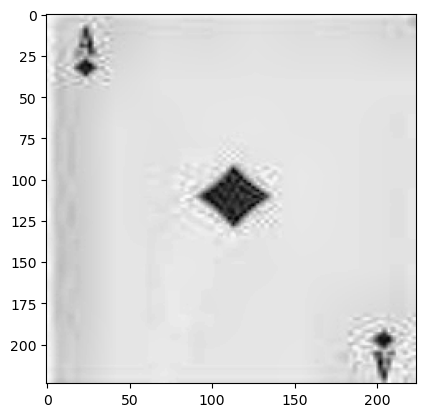

In [7]:
test_colored_image = 'train/ace of diamonds/112.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
plt.imshow(test_gray_img, cmap='gray')

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(test_gray_img)
equalized
plt.imshow(equalized, cmap='gray')

### Sharpening

In [8]:
# Sharpen images

def rmse(img1, img2):
    """Calculate and return Root mean squared error"""
    return np.sqrt(np.mean(np.square(img1 - img2)))


# create a convolution function that takes in a grayscale image and a kernel as input
# and returns the convolved image (as a numpy array)

def convolution(in_im, h):
    out_im = np.zeros(in_im.shape)
    img_height, img_width = in_im.shape
    
    # For nxn kernels
    if len(h.shape) > 1:
        kernel_height, kernel_width = h.shape
        padded_img = np.pad(in_im, (1,), 'wrap')
    # For 1D kernels
    else:
        kernel_height = 1
        kernel_width = h.shape[0]
        padded_img = np.pad(in_im, ((0,0),(1,1)), 'wrap')
    
    for height in range(img_height):
        for width in range(img_width):
            region = padded_img[height:height+kernel_height, width:width+kernel_width]
            convolution = np.sum(region * h)
            
            out_im[height, width] = convolution
    
    return out_im

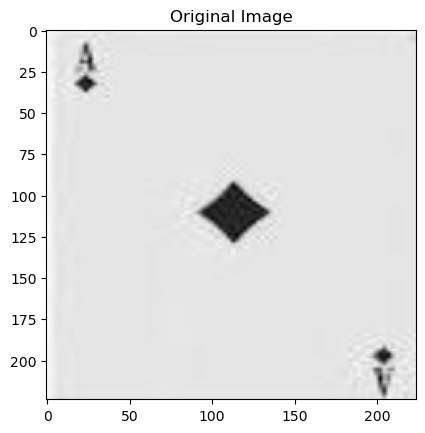

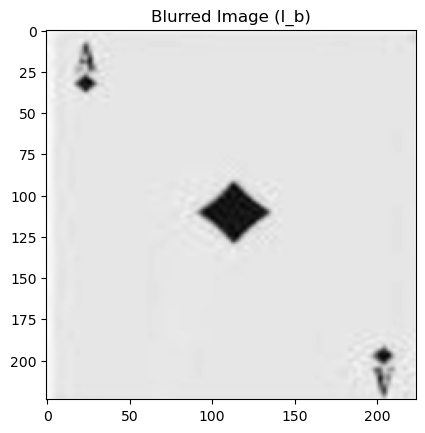

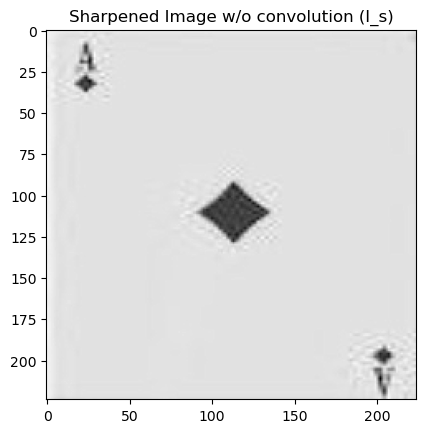

In [9]:
# Check image sharpness

im_path = 'train/ace of diamonds/112.jpg'
im = convert_to_grayscale(im_path)

h = np.array([[0.0625, 0.125, 0.0625],
              [0.125, 0.25, 0.125],
              [0.0625, 0.125, 0.0625]])

I_b = convolution(im, h)
I_h = im - I_b
I_s = I_h + im 
I_sp = convolution(im, ((np.array([[0, 0, 0], [0, 1, 0],[0, 0, 0]])*2) - h))


# Display images
plt.imshow(im, cmap='gray')
plt.title('Original Image')
plt.show()

plt.imshow(I_b, cmap='gray')
plt.title('Blurred Image (I_b)')
plt.show()

plt.imshow(I_s, cmap='gray')
plt.title('Sharpened Image w/o convolution (I_s)')
plt.show()

# plt.imshow(I_sp, cmap='gray', vmin=0, vmax=255)
# plt.title('Sharpened Image w/ convolution (I_sp)')
# plt.show()

In [10]:
# print blur score to make sure the image gets sharpened
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

im_path = 'train/ace of diamonds/112.jpg'
gray_image = convert_to_grayscale(im_path)

original_blur_score = variance_of_laplacian(gray_image)
print("Original Blur Score: ", original_blur_score)

sharpened_blur_score = variance_of_laplacian(I_sp)  # The higher the blur score, the sharper the image
print("Sharpened Blur Score: ", sharpened_blur_score)

Original Blur Score:  40.6705862674451
Sharpened Blur Score:  92.19376277635615


## Normalization

In [11]:
# Normalization

def normalize_img(img):
    normalized = (img - np.min(img))/(np.max(img) - np.min(img))   
    return normalized

[[0.66137566 0.65608466 0.64021164 ... 0.68783069 0.68783069 0.6984127 ]
 [0.65608466 0.64021164 0.66137566 ... 0.68253968 0.71428571 0.70899471]
 [0.65079365 0.65608466 0.66666667 ... 0.69312169 0.6984127  0.68783069]
 ...
 [0.66137566 0.66137566 0.57142857 ... 0.56613757 0.57142857 0.59259259]
 [0.63492063 0.60846561 0.61904762 ... 0.56613757 0.60846561 0.59259259]
 [0.64550265 0.5978836  0.62433862 ... 0.58201058 0.55555556 0.61375661]]
min 0.0
max 1.0


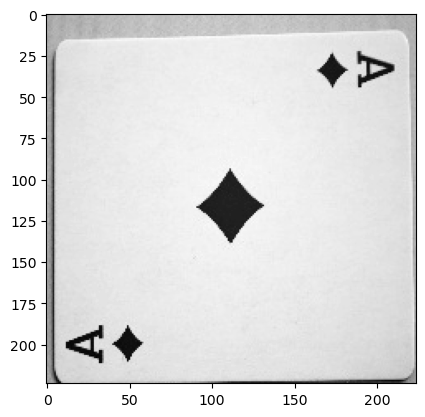

In [12]:
# Test normalization function

test_colored_image = 'train/ace of diamonds/001.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)

norm = normalize_img(test_gray_img)
print(norm)
print("min", np.min(norm))
print("max", np.max(norm))
plt.imshow(norm, cmap='gray')

## Other Preprocessing steps

### Image Filtering
Apply filters or convolutions to smooth the image or enhance specific features. This can include techniques such as blurring (e.g., Gaussian blur), edge detection (e.g., Sobel, Canny), or other spatial filters.

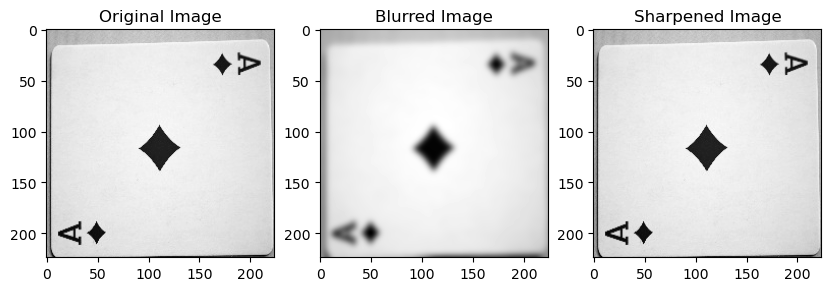

In [13]:
#BLURRING AND SHARPENING OF IMAGES USING GAUSSIAN BLUR

#Blurred and Sharpened Image using Gaussian Blur
gray_img = test_gray_img

#blurring the image
def blur_image(image):
    
    blur_img = gaussian(image, sigma = 3)
    return blur_img

#sharpening image
def sharpen_image(image):
    blurred_image = blur_image(image)
    sharp_img = image + (image - blurred_image)
    return sharp_img

#displaying images
figs, axes = plt.subplots(1,3, figsize = (10,10))

axes[0].imshow(gray_img, cmap = 'gray')
axes[0].set_title('Original Image')

axes[1].imshow(blur_image(gray_img), cmap = 'gray')
axes[1].set_title('Blurred Image')

axes[2].imshow(sharpen_image(gray_img), cmap = 'gray')
axes[2].set_title('Sharpened Image')

plt.show()

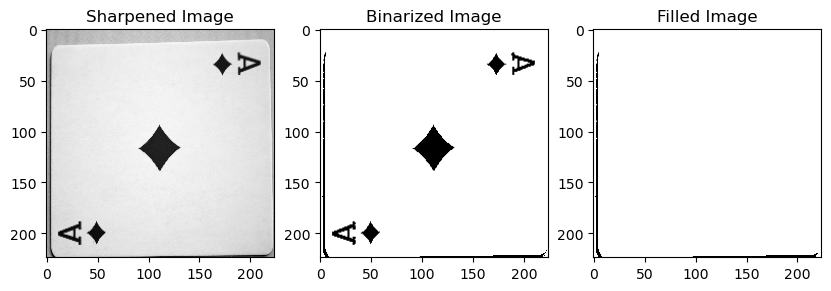

In [14]:
#THRESHOLDING, BINARIZATON AND FILLING OF IMAGES

img = sharpen_image(gray_img)

#thresholding Image
def thresholding_image(image):
    
    threshold_image = threshold_otsu(image)
    return threshold_image

#binarizing image
def binarizing_image(image):
    
    binary_image = image > thresholding_image(image)
    return binary_image

#filling image, best results are based on a binarized image
def fill_image(image):
    
    filled_image = binary_fill_holes(image)
    return filled_image
    

figs, axes = plt.subplots(1,3, figsize = (10,10))

axes[0].imshow(img, cmap = 'gray')
axes[0].set_title('Sharpened Image')

axes[1].imshow(binarizing_image(img), cmap = 'gray')
axes[1].set_title('Binarized Image')

axes[2].imshow(fill_image(binarizing_image(img)), cmap = 'gray')
axes[2].set_title('Filled Image')

plt.show()

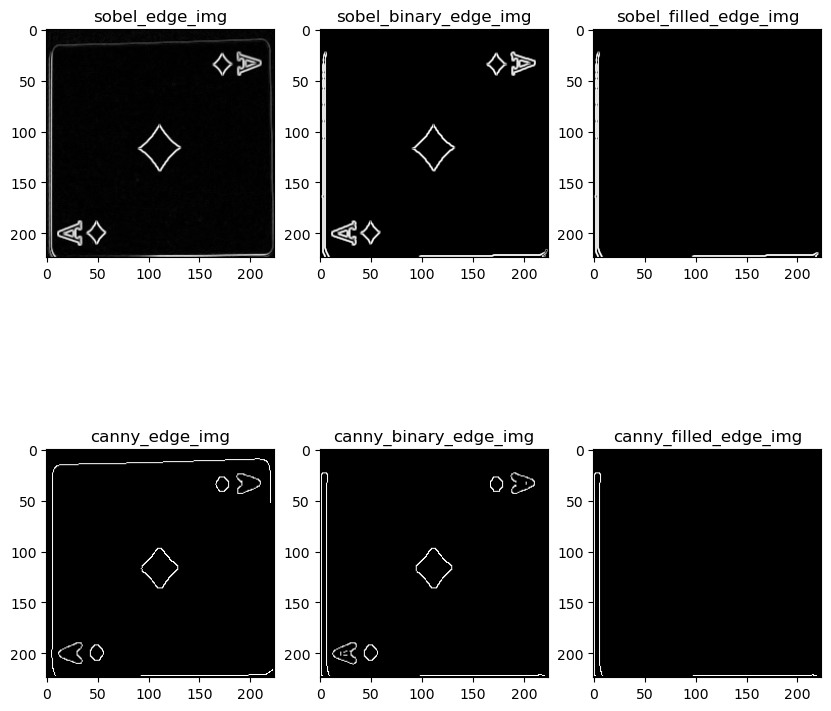

In [16]:
#EDGE DETECTION USING CANNY AND SOBEL METHODS

binary_img = binarizing_image(img)
filled_bin = fill_image(binarizing_image(img))

#sobel method
sobel_edge_img = sobel(gray_img)
sobel_binary_edge_img = sobel(binary_img) #thresholding with no filling
sobel_filled_edge_img = sobel(filled_bin) #filled image with thresholding

#canny method
canny_edge_img = canny(gray_img, sigma = 3)
canny_binary_edge_img = canny(binary_img, sigma = 3) #thresholding with no filling
canny_filled_edge_img = canny(filled_bin, sigma = 3) #filled image with thresholding

#plot images
figs, axes = plt.subplots(2,3, figsize = (10,10))

axes[0,0].imshow(sobel_edge_img, cmap = 'gray')
axes[0,0].set_title('sobel_edge_img')

axes[0,1].imshow(sobel_binary_edge_img, cmap = 'gray')
axes[0,1].set_title('sobel_binary_edge_img')

axes[0,2].imshow(sobel_filled_edge_img, cmap = 'gray')
axes[0,2].set_title('sobel_filled_edge_img')

axes[1,0].imshow(canny_edge_img, cmap = 'gray')
axes[1,0].set_title('canny_edge_img')

axes[1,1].imshow(canny_binary_edge_img, cmap = 'gray')
axes[1,1].set_title('canny_binary_edge_img')

axes[1,2].imshow(canny_filled_edge_img, cmap = 'gray')
axes[1,2].set_title('canny_filled_edge_img')

plt.show()

In [17]:
#CALCULATING ANGLES OF ROTATION
#Imperfect. None of the methods used produced a reliable angle of rotation

import warnings
warnings.filterwarnings('ignore')

def hough_line_detection(h_img, title):
    '''
    We can determing the angle of rotation based on the angle between the identified hough lines (theta) detected
    '''
    h, theta, d = hough_line(h_img)
    besth, besttheta, bestd = hough_line_peaks(h, theta, d)
    
    if len(besttheta) > 0:
        r_angle = np.rad2deg(mode(besttheta)[0][0])
        
    else:
        r_angle = 0
#     print(f'{title}, rotation angle: {r_angle}')
    return r_angle

#rotation angle based on the different edge detection methods used

se_img = hough_line_detection(sobel_edge_img, 'sobel edge')
sbe_img = hough_line_detection(sobel_binary_edge_img, 'sobel edge with threshold and no fill')
sfe_img = hough_line_detection(sobel_filled_edge_img, 'sobel edge with threshold and fill')

ce_img = hough_line_detection(canny_edge_img, 'canny edge ')
cbe_img = hough_line_detection(canny_binary_edge_img, 'canny edge with threshold and no fill')
cfe_img = hough_line_detection(canny_filled_edge_img, 'canny edge with threshold and fill')

### Data Augmentation
Apply data augmentation techniques to increase the size and diversity of your dataset. This can include random rotations, flips, translations, or other transformations to simulate different viewpoints or variations in lighting conditions.

In [21]:
#AUGMENTATION FUNCTIONS

#specified rotation
def image_rotation(image, angle_of_rotation):
    
    #rotate the image based on the rotation angle provided
    rotate_img = rotate(image, angle_of_rotation, resize = True)
    
    #resize the image if the size changed
    if rotate_img.shape != image.shape:
        rotated_img = resize(rotate_img, image.shape)
    else:
        rotated_img = rotate_img
     
    #return the final image
    return rotated_img


#random rotation function
def random_rotation(image):
    
    #randomly determine the rotation angle
    random_rotation = np.random.uniform(low = 0.0, high = 360.0)
    
    #rotate the image
    rotate_img = rotate(image, random_rotation, resize = True)
    
    #resize the image if the size changed
    if rotate_img.shape != image.shape:
        rotated_img = resize(rotate_img, image.shape)
    else:
        rotated_img = rotate_img
        
    #return the final image
    return rotated_img


#random flipping function
def random_flip(image):
    
    #generate a method to determine how the image should be flipped
    random_flip_axis = np.random.randint(low = 1, high = 4, dtype = int)
    
    #flip horizontal
    if random_flip_axis == 1:
        flipped_image = image[:, ::-1]
     
    #flip vertical
    elif random_flip_axis == 2:
        flipped_image = image[::-1, :]
    
    #No flip    
    elif random_flip_axis == 3:
        flipped_image = image
    
    #return the flipped image
    return flipped_image
 

#gamma correction - adjusts brightness of image
def gamma_correction(image):
    random_gamma = np.random.uniform(low = 0, high = 1)
    
    gamma_adjusted_image = exposure.adjust_gamma(image, 2)
    return gamma_adjusted_image


#logarithmic correction - replaces pixels with their log value
def log_correction(image):
    log_adjusted_image =  exposure.adjust_log(image)
    return log_adjusted_image


#data augmentation function
def data_augemntation(image):
    random_correction = np.random.randint(low = 1, high = 4, dtype = int)
    
    rotated_image = random_rotation(image)
    flipped_image = random_flip(rotated_image)
    
    #random correction of the image
    if random_correction == 1:
        augmentated_image = gamma_correction(flipped_image)
        
    elif random_correction == 2:
        augmentated_image = log_correction(flipped_image)
    
    elif random_correction == 3:
        augmentated_image = flipped_image
    
    return augmentated_image

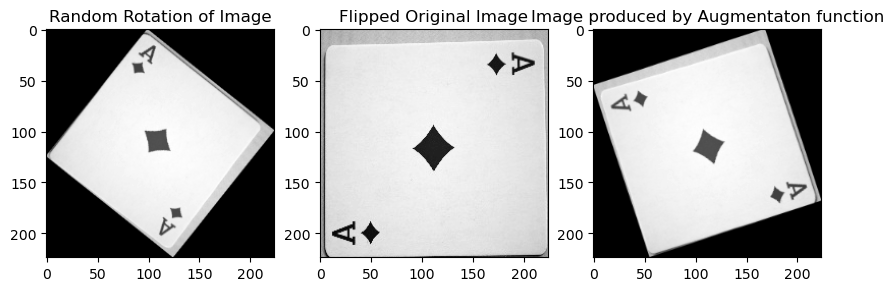

In [22]:
#Displaying of Augmented Images
rotated_img = random_rotation(gray_img) #random rotation

flipped_original_image = random_flip(gray_img) #flipping the original image

augmentated_image = data_augemntation(gray_img) #data augmentation funtion

#plotting the flipped and rotated images
fig, axes = plt.subplots(1,3, figsize = (10,10))

axes[0].imshow(rotated_img, cmap = 'gray')
axes[0].set_title('Random Rotation of Image')

axes[1].imshow(flipped_original_image, cmap = 'gray')
axes[1].set_title('Flipped Original Image')

axes[2].imshow(augmentated_image, cmap = 'gray')
axes[2].set_title('Augmentaton Image')

plt.show()

## Working on code for slanted images

In [ ]:
# Load the slanted card image

image = cv2.imread('Dataset/train/ace of diamonds/063.jpg')

# Convert the image to grayscale
gray = convert_to_grayscale('train/ace of diamonds/063.jpg')

# Perform edge detection (e.g., Canny edge detection)
edges = cv2.Canny(gray, 50, 150)

# Find contours and approximate the card contour
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
card_contour = max(contours, key=cv2.contourArea)
epsilon = 0.02 * cv2.arcLength(card_contour, True)
approx = cv2.approxPolyDP(card_contour, epsilon, True)

# # Determine target corners and points
target_corners = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
source_corners = np.float32([approx[0][0], approx[1][0], approx[2][0], approx[3][0]])

# # Compute perspective transformation matrix
transform_matrix = cv2.getPerspectiveTransform(source_corners, target_corners)

# # Define the dimensions for the rectified image
width = 500  # Desired width for the rectified image
height = 700  # Desired height for the rectified image

# Apply perspective transformation to rectify the image
rectified = cv2.warpPerspective(image, transform_matrix, (width, height))

plt.imshow(rectified)


In [ ]:
%matplotlib tk
def white_patch(input_img):
    # TODO: get point(s) from user (choose a point)
    # compute scale factors for each color channel (calculate average color of region around point)
    # rescale each color channel (multiply invers proportion of region average by each channel)
    
    plt.imshow(input_img)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.title('Choose a white point on the image')
    
    point = plt.ginput(2)
    point = (int(point[0][0]), int(point[0][1]))
    
    region = input_img[point[1]-10:point[1]+10, point[0]-10:point[0]+10]
    region_avg_color = np.mean(region, axis=(0,1))
    scale_region = 1/region_avg_color
    
    wb_img = input_img.copy()
    wb_img[:,:,0] *= scale_region[0]
    wb_img[:,:,1] *= scale_region[1]
    wb_img[:,:,2] *= scale_region[2]
    
    wb_img = np.clip(wb_img, 0, 1)
    
    return wb_img

gray_world_output = gray_world(input_img)
white_patch_output = white_patch(input_img)

%matplotlib inline
fig1 = plt.figure()
plt.imshow(gray_world_output)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('Gray-World')
plt.show()

fig2 = plt.figure()
plt.imshow(white_patch_output)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('White-Patch')
plt.show()

In [ ]:
%matplotlib tk
image = cv2.imread('Dataset/train/ace of diamonds/063.jpg')
gray = convert_to_grayscale('train/ace of diamonds/063.jpg')

plt.imshow(gray, cmap='gray')

plt.xticks(ticks=[])
plt.yticks(ticks=[])
point = plt.ginput(4)
# point = (int(point[0][0]), int(point[0][1]))
plt.close()

for p in point:
    print(p)

In [ ]:
def get_image_corners(image_path):
    # Load the image in grayscale
#     image = cv2.imread(image_path, 0)
#     image = cv2.imread('Dataset/train/ace of diamonds/063.jpg')
    image = convert_to_grayscale(image_path)
    
    # Set the parameters for corner detection
    max_corners = 4
    quality_level = 0.01
    min_distance = 10
    block_size = 3
    
    # Perform corner detection
    corners = cv2.goodFeaturesToTrack(gray, max_corners, quality_level, min_distance, blockSize=block_size)
    
    # Convert the corner coordinates to integers
    corners = np.int0(corners)
    
    # Extract and return the corner points
    image_corners = [corner.ravel() for corner in corners]
    return image_corners

# Specify the path to the image
image_path = 'train/ace of diamonds/063.jpg'

# Get the image corners
corners = get_image_corners(image_path)

# Print the corner points
print("Image Corners:")
for corner in corners:
    print(corner)

In [ ]:
gray = convert_to_grayscale('train/ace of diamonds/063.jpg')
corner_detector = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

corner_detector = cv2.dilate(corner_detector, None)
threshold = 0.01 * corner_detector.max()
_, corner_mask = cv2.threshold(corner_detector, threshold, 255, cv2.THRESH_BINARY)
corner_mask = np.uint8(corner_mask)
_, contours, _ = cv2.findContours(corner_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
corners = np.float32([corner[0] for corner in contours[0]])

corners = sort_corners_clockwise(corners)

print(corners)
